In [1]:
# transfer_learning 디렉토리에서 jupyter notebook을 실행했을 경우 
# 아래와 같이 dataloader와 같은 모듈의 경로를 등록해야한다.
import sys
sys.path.insert(0, "Chapter07/.")

In [2]:
import config
from dataloader.loader import Loader
from preprocessing.utils import Preprocess, remove_empty_docs
from dataloader.embeddings import GloVe
from model.cnn_document_model import DocumentModel, TrainingParameters
from keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
from keras.utils import to_categorical
import keras.backend as K

from sklearn.manifold import TSNE

## Load Data Sets for 20 News Group

In [3]:
dataset = Loader.load_20newsgroup_data(subset='train')
corpus, labels = dataset.data, dataset.target
corpus, labels = remove_empty_docs(corpus, labels)


test_dataset = Loader.load_20newsgroup_data(subset='test')
test_corpus, test_labels = test_dataset.data, test_dataset.target
test_corpus, test_labels = remove_empty_docs(test_corpus, test_labels)

## Mapping 20 Groups to 6 High level Categories 

In [4]:
six_groups = {
    'comp.graphics':0,'comp.os.ms-windows.misc':0,'comp.sys.ibm.pc.hardware':0,
    'comp.sys.mac.hardware':0, 'comp.windows.x':0,
    
    'rec.autos':1, 'rec.motorcycles':1, 'rec.sport.baseball':1, 'rec.sport.hockey':1,
    
    'sci.crypt':2, 'sci.electronics':2,'sci.med':2, 'sci.space':2,
    
    'misc.forsale':3,
    
    'talk.politics.misc':4, 'talk.politics.guns':4, 'talk.politics.mideast':4,
    
    'talk.religion.misc':5, 'alt.atheism':5, 'soc.religion.christian':5
    
}

In [5]:
map_20_2_6 = [six_groups[dataset.target_names[i]] for i in range(20)]
labels = [six_groups[dataset.target_names[i]] for i in labels] 
test_labels = [six_groups[dataset.target_names[i]] for i in test_labels] 

## Pre-process Text to convert it to word index sequences

In [6]:
# nltk 다운로드 필요
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/dyanos/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [7]:
Preprocess.MIN_WD_COUNT=5
preprocessor = Preprocess(corpus=corpus)
corpus_to_seq = preprocessor.fit()

Found 19538 unique tokens.
All documents processed.cessed.

In [8]:
test_corpus_to_seq = preprocessor.transform(test_corpus)

All documents processed.cessed.

## Initialize Embeddings

In [ ]:
# glove를 다운로드 받는다.
#!wget http://nlp.stanford.edu/data/glove.6B.zip
#!unzip glove.6B.zip -d glove.6B
# 그리고 config.py파일에서 GloVe에 대한 path를 적절히 수정해야 한다.

In [9]:
glove=GloVe(50)
initial_embeddings = glove.get_embedding(preprocessor.word_index)

Reading 50 dim GloVe vectors
Found 400000 word vectors.
words not found in embeddings: 1268


## Build Model

In [10]:
newsgrp_model = DocumentModel(vocab_size=preprocessor.get_vocab_size(),
                                    sent_k_maxpool = 5,
                                    sent_filters = 20,
                                    word_kernel_size = 5,
                                    word_index = preprocessor.word_index,
                                    num_sentences=Preprocess.NUM_SENTENCES,                                    
                                    embedding_weights=initial_embeddings,
                                    conv_activation = 'relu',
                                    train_embedding = True,
                                    learn_word_conv = True,
                                    learn_sent_conv = True,
                                    sent_dropout = 0.4,
                                    hidden_dims=64,                                        
                                    input_dropout=0.2, 
                                    hidden_gaussian_noise_sd=0.5,
                                    final_layer_kernel_regularizer=0.1,
                                    num_hidden_layers=2,
                                    num_units_final_layer=6)


Vocab Size = 19540  and the index of vocabulary words passed has 19538 words
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


## Save model parameters

In [11]:
train_params = TrainingParameters('6_newsgrp_largeclass', 
                                  model_file_path = config.MODEL_DIR+ '/20newsgroup/model_6_01.hdf5',
                                  model_hyper_parameters = config.MODEL_DIR+ '/20newsgroup/model_6_01.json',
                                  model_train_parameters = config.MODEL_DIR+ '/20newsgroup/model_6_01_meta.json',
                                  num_epochs=20,
                                  batch_size = 128,
                                  validation_split=.10,
                                  learning_rate=0.01)

train_params.save()
newsgrp_model._save_model(train_params.model_hyper_parameters)

## Compile and run model

In [12]:
newsgrp_model._model.compile(loss="categorical_crossentropy", 
                            optimizer=train_params.optimizer,
                            metrics=["accuracy"])
checkpointer = ModelCheckpoint(filepath=train_params.model_file_path,
                                   verbose=1,
                                   save_best_only=True,
                                   save_weights_only=True)

early_stop = EarlyStopping(patience=2)

In [13]:

x_train = np.array(corpus_to_seq)
y_train  = to_categorical(np.array(labels))

x_test = np.array(test_corpus_to_seq)
y_test = to_categorical(np.array(test_labels))


In [14]:
#Set LR
K.set_value(newsgrp_model.get_classification_model().optimizer.lr, train_params.learning_rate)

newsgrp_model.get_classification_model().fit(x_train, y_train, 
                      batch_size=train_params.batch_size, 
                      epochs=train_params.num_epochs,
                      verbose=2,
                      validation_split=train_params.validation_split,
                      callbacks=[checkpointer,early_stop])

newsgrp_model.get_classification_model().evaluate( x_test, y_test,  verbose=2)
preds = newsgrp_model.get_classification_model().predict(x_test)
preds_test = np.argmax(preds, axis=1)


Train on 9912 samples, validate on 1102 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/20

Epoch 00001: val_loss improved from inf to 1.11811, saving model to .//20newsgroup/model_6_01.hdf5
 - 9s - loss: 1.7577 - acc: 0.4076 - val_loss: 1.1181 - val_acc: 0.5681
Epoch 2/20

Epoch 00002: val_loss improved from 1.11811 to 0.79159, saving model to .//20newsgroup/model_6_01.hdf5
 - 7s - loss: 0.9806 - acc: 0.6757 - val_loss: 0.7916 - val_acc: 0.7450
Epoch 3/20

Epoch 00003: val_loss improved from 0.79159 to 0.73553, saving model to .//20newsgroup/model_6_01.hdf5
 - 7s - loss: 0.7439 - acc: 0.7626 - val_loss: 0.7355 - val_acc: 0.7777
Epoch 4/20

Epoch 00004: val_loss improved from 0.73553 to 0.65603, saving model to .//20newsgroup/model_6_01.hdf5
 - 7s - loss: 0.6028 - acc: 0.8059 - val_loss: 0.6560 - val_acc: 0.7976
Epoch 5/20

Epoch 00005: val_loss did not improve from 0.65603
 - 7s - loss: 0.5014 - acc: 0.8429 - val_loss: 0.6992 - val_acc: 0.7886
Epoch 6/20

Epoch 00006: 

## Evaluate Model Accuracy

In [15]:
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
print(classification_report(test_labels, preds_test))
print(confusion_matrix(test_labels, preds_test))
print(accuracy_score(test_labels, preds_test))

              precision    recall  f1-score   support

           0       0.83      0.87      0.85      1912
           1       0.78      0.92      0.84      1534
           2       0.75      0.76      0.75      1523
           3       0.72      0.35      0.47       382
           4       0.75      0.79      0.77      1027
           5       0.90      0.67      0.77       940

   micro avg       0.79      0.79      0.79      7318
   macro avg       0.79      0.72      0.74      7318
weighted avg       0.79      0.79      0.78      7318

[[1662   71  148   21    7    3]
 [  25 1404   45   18   35    7]
 [ 150  121 1151   11   71   19]
 [ 144   72   29  132    4    1]
 [   6   79   90    1  811   40]
 [  17   62   73    1  159  628]]
0.7909264826455316


## Visualization: Document Embeddings with tsne - what the model learned

In [16]:
from utils import scatter_plot
doc_embeddings = newsgrp_model.get_document_model().predict(x_test)
print(doc_embeddings.shape)

(7318, 80)


In [17]:
doc_proj = TSNE(n_components=2, random_state=42, ).fit_transform(doc_embeddings)

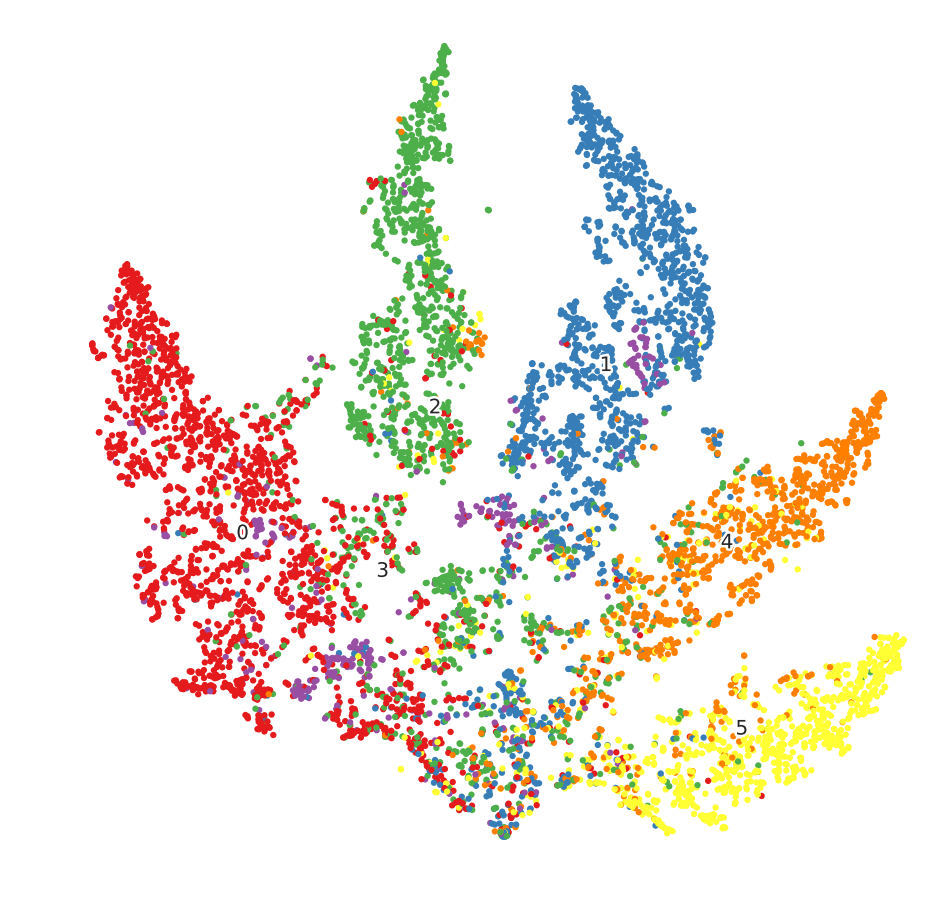

In [21]:
f = scatter_plot(doc_proj, np.array(test_labels))

In [22]:
f

(<Figure size 1152x1152 with 1 Axes>,
 [Text(-56.647293, -5.484208, '0'),
  Text(21.654089, 25.364202, '1'),
  Text(-15.188355, 17.606525, '2'),
  Text(-26.464165, -12.385736, '3'),
  Text(47.716713, -7.1654677, '4'),
  Text(50.91315, -41.317497, '5')],
 <module 'matplotlib.pyplot' from '/home/dyanos/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>)

In [23]:
f[0].savefig('nws_grp_embd.png')